# TMDB Box Office Prediction

### Introduction

In a world... where movies made an estimated $41.7 billion in 2018, the film industry is more popular than ever. But what movies make the most money at the box office? How much does a director matter? Or the budget? For some movies, it's "You had me at 'Hello.'" For others, the trailer falls short of expectations and you think "What we have here is a failure to communicate."

In this, we're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release.


### Load Libraries

In [1]:
#Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import ast
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
from urllib.request import urlopen

### Load Data

In [2]:
train = pd.read_csv('/Users/adamyanayyar/Desktop/SpringBoard/Projects/Capstone 2/tmdb-box-office-prediction-data/train.csv')
test = pd.read_csv('/Users/adamyanayyar/Desktop/SpringBoard/Projects/Capstone 2/tmdb-box-office-prediction-data/test.csv')

dict_columns = ['belongs_to_collection','genres','spoken_languages','production_companies',
                'production_countries','Keywords','cast','crew']

def text_to_dict(df):
    for columns in dict_columns:
        df[columns] = df[columns].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return df

train = text_to_dict(train)
test = text_to_dict(test)

In [3]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
train.shape , test.shape

((3000, 23), (4398, 22))

There are only 3000 rows to train the data.
We can see that some of columns contain lists with dictionaries. Some lists contain a single dictionary, some have several. Let's extract data from these columns!
#### Belongs to collection

In [5]:
for i,e in enumerate(train['belongs_to_collection'][:5]):
    print(i,e)

0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}


In [6]:
train['belongs_to_collection'].apply(lambda x: 1 if x!= {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

2396 dont have any value. 604 have collection values. We will store collection name separtely as another features, as rest of the values won't be much needed, so we'll drop them.

In [7]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] 
                                                                if x!={} else 0 )
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) 
                                                               if x!={} else 0)
test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] 
                                                                if x!={} else 0 )
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) 
                                                               if x!={} else 0)
train.drop('belongs_to_collection',axis=1,inplace= True)
test.drop('belongs_to_collection',axis=1,inplace= True)

In [8]:
train.head()

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,0
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,0,0


Similarly we will check all the dictionaries and clean them.
Now we will check for Genres.
#### Genres

In [9]:
for i,e in enumerate(train['genres'][:5]):
    print(i,e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [10]:
print('Number of genres in films:')
train['genres'].apply(lambda x: len(x) if x!={} else 0).value_counts()

Number of genres in films:


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

This shows that majority of the films have 2-3 genres. 5-6 are also possible but 0-7 might be outliers. 

In [11]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x!={} else []).values)

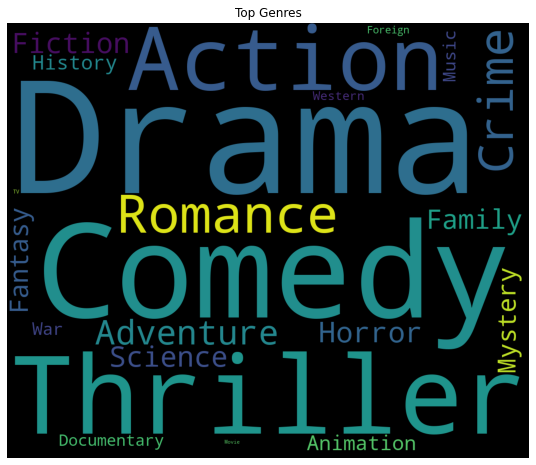

In [12]:
plt.figure(figsize=(12,8))
text = ' '.join(i for j in list_of_genres for i in j)
wordcloud = WordCloud(max_font_size = None, width = 1200, height = 1000,
                      collocations =False).generate(text)
plt.imshow(wordcloud)
plt.title('Top Genres')
plt.axis('off')
plt.show()

As we can see, Drama, Comedy, Thriller , Action are the most common genres.

In [13]:
Counter([i for j in list_of_genres for i in j]).most_common(15)

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100)]

In [14]:
top_genres =[m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
print(top_genres)

['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Crime', 'Adventure', 'Horror', 'Science Fiction', 'Family', 'Fantasy', 'Mystery', 'Animation', 'History', 'Music']


As we can see, Drama and Comedy are the most common genres.
We can create separate features. 
One for num of genres.
Another for value of all genres.
and then for most common genres.

In [15]:
train['num_of_genres'] = train['genres'].apply(lambda x: len(x) if x!={} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x ])) 
                                           if x!= {} else '')
test['num_of_genres'] = test['genres'].apply(lambda x: len(x) if x!={} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x ])) 
                                           if x!= {} else '')

In [16]:
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)

In [17]:
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)
train.drop(['genres'],axis =1)
test = test.drop(['genres'], axis =1)

In [18]:
train.drop('genres',axis=1,inplace=True)

Now let's look briefly at production companies.
#### Production Companies

In [19]:
for i,e in enumerate(train['production_companies'][:5]):
    print(i,e)


0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [20]:
print('Number of Production Companies for a movie:')
train['production_companies'].apply(lambda x: len(x) if x!= {} else 0).value_counts()

Number of Production Companies for a movie:


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

As you can see, majority of the movie's have 1-3 production companies.
There are movie's with more than 10 production companies. We will have a look at these companies to check if the data is valid.

In [21]:
train[train['production_companies'].apply(lambda x: len(x) if x!= {} else 0) > 10]

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection,num_of_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music
31,32,0,http://www.cache-derfilm.at,tt0387898,fr,Caché,A married couple is terrorized by a series of ...,5.695860,/i1Zl8S4DgM3IDLW5dhZzBnIdCOe.jpg,"[{'name': 'Les Films du Losange', 'id': 223}, ...","[{'iso_3166_1': 'AT', 'name': 'Austria'}, {'is...",5/2/05,117.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Caché,"[{'id': 90, 'name': 'paris'}, {'id': 213, 'nam...","[{'cast_id': 2, 'character': 'Georges Laurent'...","[{'credit_id': '52fe4244c3a36847f8011073', 'de...",36000000,0,0,3,Drama Mystery Thriller,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
116,117,0,NaN,tt2113822,zh,一九四二,"In 1942, Henan Province was devastated by the ...",1.678013,/xxz2gi8vijqqJySGO3kQy2i8mv.jpg,"[{'name': 'Emperor Motion Pictures', 'id': 272...","[{'iso_3166_1': 'CN', 'name': 'China'}]",11/1/12,145.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Back to 1942,"[{'id': 478, 'name': 'china'}, {'id': 180999, ...","[{'cast_id': 3, 'character': 'Theodore Harold ...","[{'credit_id': '5761375dc3a36808aa001554', 'de...",311,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
363,364,15400000,NaN,tt2053425,fr,De rouille et d'os,"Put in charge of his young son, Ali leaves Bel...",8.400049,/cHCwW8xPl8yPKQwpNzKVinwvirT.jpg,"[{'name': 'France 2 Cinéma', 'id': 83}, {'name...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",5/17/12,123.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Rust and Bone,"[{'id': 494, 'name': 'father son relationship'...","[{'cast_id': 2, 'character': 'St√©phanie', 'cr...","[{'credit_id': '52fe49dd9251416c750d5e05', 'de...",25762027,0,0,2,Drama Romance,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
392,393,0,NaN,tt5072406,fr,Moka,Diane Kramer is led by one obsession: to find ...,2.404466,/5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg,"[{'name': 'Canal+', 'id': 5358}, {'name': 'Cin...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",8/17/16,89.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,NaN,Moka,{},"[{'cast_id': 1, 'character': 'Diane', 'credit_...","[{'credit_id': '59619ddd9251410bfa0cf8e5', 'de...",126463,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
449,450,80000000,http://asoundofthunder.warnerbros.com/,tt0318081,en,A Sound of Thunder,When a hunter sent back to the prehistoric era...,4.980191,/gsqOX1ReJ5lcmTuDdkhOXLug8Ug.jpg,"[{'name': 'Epsilon Motion Pictures', 'id': 117...","[{'iso_3166_1': 'CZ', 'name': 'Czech Republic'...",5/15/05,110.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Some Rules Should Never Be Broken.,A Sound of Thunder,"[{'id': 3737, 'name': 'dying and death'}, {'id...","[{'cast_id': 34, 'character': 'Alicia Wallenbe...","[{'credit_id': '52fe431e9251416c7500438b', 'de...",5989640,0,0,4,Action Adventure Science Fiction Thriller,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0
554,555,14500000,NaN,tt0293416,ja,Metropolis,Duke Red has overseen the construction of a ma...,9.298092,/1EK7mGCpRKYmSg25FaojvnS9opm.jpg,"[{'name': 'Bandai Visual Company', 'id': 528},...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",5/26/01,108.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...",Released,Welcome to Metropolis,Metropolis,"[{'id': 931, 'name': 'jealousy'}, {'id': 1761,...","[{'cast_id': 1, 'character': 'Tima (voice)', '...","[{'credit_id': '52fe4510c3a36847f80ba41d', 'de...",95789342,0,0,2,Animation Science Fiction,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
774,775,0,NaN,tt0798817,en,13,A naive young man assumes a dead man's identit...,14.679860,/8w54aZ5hLX18gqs37MIdBmyIFMN.jpg,"[{'name': 'Tax Credit Finance', 'id': 3782}, {...","[{'iso_3166_1': 'US', 'name': '

All of the movie's look real, so we will keep the data.

Now lets see the most common production companies.

In [22]:
list_of_companies = list(train['production_companies'].apply(lambda x : [i['name'] for i in x] 
                                                            if x!= {} else []).values)

In [23]:
Counter(i for j in list_of_companies for i in j).most_common(30)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23)]

We will create binary columns for the top 30 production house and later see what we do with this data. We will also create additional features.

In [24]:
train['num_prod_companies'] = train['production_companies'].apply(lambda x: len(x) if
                                                                 x!={} else 0)
test['num_prod_companies'] = test['production_companies'].apply(lambda x: len(x) if 
                                                               x!={} else 0)
train['all_prod_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x!={} else '' )
test['all_prod_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x!={} else '')

In [25]:
top_prod_companies = [m[0] for m in Counter(i for j in list_of_companies for i in j).most_common(30)]
for pc in top_prod_companies:
    train['production_' + pc] = train['all_prod_companies'].apply(lambda x: 1 if pc in x else 0)
    test['production_'+ pc] = test['all_prod_companies'].apply(lambda x: 1 if pc in x else 0)

In [26]:
train.drop(['production_companies','all_prod_companies'],axis = 1, inplace = True)
test.drop(['production_companies','all_prod_companies'],axis =1, inplace = True)

In [27]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection,num_of_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_prod_companies,production_Warner Bros.,production_Universal Pictures,production_Paramount Pictures,production_Twentieth Century Fox Film Corporation,production_Columbia Pictures,production_Metro-Goldwyn-Mayer (MGM),production_New Line Cinema,production_Touchstone Pictures,production_Walt Disney Pictures,production_Columbia Pictures Corporation,production_TriStar Pictures,production_Relativity Media,production_Canal+,production_United Artists,production_Miramax Films,production_Village Roadshow Pictures,production_Regency Enterprises,production_BBC Films,production_Dune Entertainment,production_Working Title Films,production_Fox Searchlight Pictures,production_StudioCanal,production_Lionsgate,production_DreamWorks SKG,production_Fox 2000 Pictures,production_Summit Entertainment,production_Hollywood Pictures,production_Orion Pictures,production_Amblin Entertainment,production_Dimension Films
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,The Princess Diaries Collection,1,4,Comedy Drama Family Romance,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1200000,http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,0,0,2,Drama Thriller,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,"[{'iso_

Similarly we will check for production countries.
#### Production Countries

In [28]:
for i, e in enumerate(train['production_countries'][:5]):
    print(i,e)

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [29]:
print('Number of Production Countries in Movies:')
train['production_countries'].apply(lambda x: len(x) if x!={} else 0).value_counts()

Number of Production Countries in Movies:


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

Majority of the movies have 1 or 2 production countries. Some movies have more. Let's check the movie's with more than 5 production countries.

In [30]:
train[train['production_countries'].apply(lambda x: len(x) if x!= {} else 0) > 5]

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,collection_name,has_collection,num_of_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_prod_companies,production_Warner Bros.,production_Universal Pictures,production_Paramount Pictures,production_Twentieth Century Fox Film Corporation,production_Columbia Pictures,production_Metro-Goldwyn-Mayer (MGM),production_New Line Cinema,production_Touchstone Pictures,production_Walt Disney Pictures,production_Columbia Pictures Corporation,production_TriStar Pictures,production_Relativity Media,production_Canal+,production_United Artists,production_Miramax Films,production_Village Roadshow Pictures,production_Regency Enterprises,production_BBC Films,production_Dune Entertainment,production_Working Title Films,production_Fox Searchlight Pictures,production_StudioCanal,production_Lionsgate,production_DreamWorks SKG,production_Fox 2000 Pictures,production_Summit Entertainment,production_Hollywood Pictures,production_Orion Pictures,production_Amblin Entertainment,production_Dimension Films
71,72,0,http://www.motorcyclediariesmovie.com/,tt0318462,es,Diarios de motocicleta,"""The Motorcycle Diaries"" is based on the journ...",7.667491,/uNMLsBv48WwIohS7n5DVe1fsFcb.jpg,"[{'iso_3166_1': 'BR', 'name': 'Brazil'}, {'iso...",2/6/04,126.0,"[{'iso_639_1': 'qu', 'name': ''}, {'iso_639_1'...",Released,Before he changed the world the world changed ...,The Motorcycle Diaries,"[{'id': 983, 'name': 'brazilian'}, {'id': 2020...","[{'cast_id': 2, 'character': 'Ernesto Guevara ...","[{'credit_id': '52fe4309c3a36847f8035923', 'de...",16756372,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1331,1332,0,NaN,tt2258858,ar,وجدة‎‎,Wadjda is a 10-year-old girl living in a subur...,5.451273,/biXHIcuUANrqkCspBNQK1dO79Z5.jpg,"[{'iso_3166_1': 'SA', 'name': 'Saudi Arabia'},...",8/31/12,98.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}]",Released,NaN,Wadjda,"[{'id': 3797, 'name': 'bicycle'}, {'id': 4097,...","[{'cast_id': 2, 'character': 'Mother', 'credit...","[{'credit_id': '52fe4b33c3a368484e17ceb7', 'de...",1347747,0,0,1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1338,1339,12000000,NaN,tt0396707,en,The Secret of Moonacre,When 13 year old Maria Merryweather's father d...,12.013340,/kwotU0j6f0lJ1UGVI9b9p8udpEF.jpg,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",9/6/08,103.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Magical Journey Begins.,The Secret of Moonacre,{},"[{'cast_id': 1, 'character': 'Sir Benjamin Mer...","[{'credit_id': '56928ff092514115c2002438', 'de...",7070330,0,0,6,Adventure Drama Family Fantasy Romance Science...,1,0,0,0,1,0,1,0,1,1,1,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2314,2315,0,NaN,tt1821641,en,The Congress,More than two decades after catapulting to sta...,8.534039,/nnKX3ahYoT7P3au92dNgLf4pKwA.jpg,"[{'iso_3166_1': 'BE', 'name': 'Belgium'}, {'is...",5/16/13,122.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,The Congress,"[{'id': 10336, 'name': 'animation'}]","[{'cast_id': 5, 'character': 'Robin Wright', '...","[{'credit_id': '55c0d60e9251410f19001cec', 'de...",455815,0,0,3,Animation Drama Science Fiction,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


There are only 4 movies with more than 5 production countries, all of which look valid. Now let's see which are the most common production countries.

In [31]:
List_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] 
                                                             if x!= {} else []))
#Count of production countries in movies
Counter(i for j in List_of_countries for i in j).most_common(25)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10)]

In [32]:
print('Number of production countries for movies:')
train['production_countries'].apply(lambda x: len(x) if x!={} else 0).value_counts()

Number of production countries for movies:


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

In [33]:
train['num_prod_countries'] = train['production_countries'].apply(lambda x: len(x) if x!= {} 
                                                                  else 0)
test['num_prod_countries'] = test['production_countries'].apply(lambda x: len(x) if x!={}
                                                               else 0)
train['all_prod_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted(i['name'] for i in x))
                                                                 if x!= {} else '')
test['all_prod_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted(i['name'] for i in x))
                                                               if x!= {} else '')


In [34]:
top_prod_countries = [m[0] for m in Counter(i for j in List_of_countries for i in j).most_common(30)]
for t in top_prod_countries:
    train['prod_country_' + t] = train['all_prod_countries'].apply(lambda x: 1 if t in x else 0)
    test['prod_country_'+ t] = test['all_prod_countries'].apply(lambda x: 1 if t in x else 0)
train.drop(['production_countries','all_prod_countries'],axis = 1, inplace = True)
test.drop(['production_countries','all_prod_countries'],axis=1, inplace = True)

#### Spoken Languages

In [35]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i,e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [36]:
print('Number of languages for a movie:')
train['spoken_languages'].apply(lambda x: len(x) if x!={} else 0).value_counts()

Number of languages for a movie:


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

This shows that most of the movies have 1-2 languages.

In [37]:
list_of_langs = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x]
                                                    if x!= {} else []))

In [38]:
top_langs = [m[0] for m in Counter(i for j in list_of_langs for i in j).most_common(15)]
Counter(i for j in list_of_langs for i in j).most_common(15)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

In [39]:
train['num_of_langs'] = train['spoken_languages'].apply(lambda x: len(x) if x!= {} else 0)
test['num_of_langs'] = test['spoken_languages'].apply(lambda x: len(x) if x!= {} else 0)

train['all_langs'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name']for i in x]))
                                                    if x!= {} else '')
test['all_langs'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x]))
                                                  if x!= {} else '')

for l in top_langs:
    train['lang_' + l] = train['all_langs'].apply(lambda x: 1 if l in x else 0)
    test['lang_'+ l] = test['all_langs'].apply(lambda x: 1 if l in x else 0)

In [40]:
train.drop(['spoken_languages','all_langs'],axis=1,inplace= True)
test.drop(['spoken_languages','all_langs'],axis= 1, inplace= True)

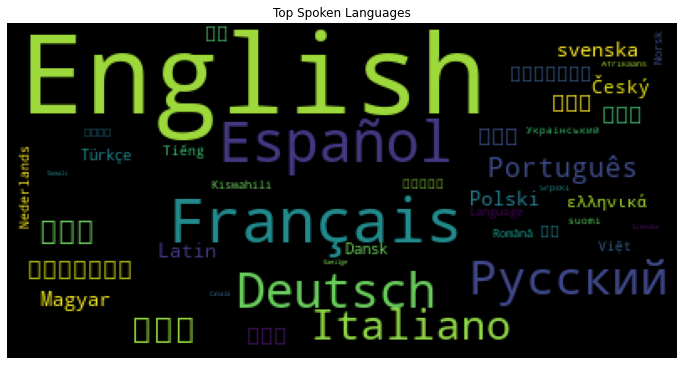

In [41]:
plt.figure(figsize=(12,8))
text2 = ' '.join(i for j in list_of_langs for i in j)
wordcloud2 = WordCloud(collocations=False).generate(text2)
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Top Spoken Languages')
plt.show()

#### Keywords

In [42]:
for i, e in enumerate(train['Keywords'][:5]):
    print(i,e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [43]:
list_of_keys = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x!= {} else []))
Counter(i for j in list_of_keys for i in j).most_common(20)

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123),
 ('based on novel', 111),
 ('violence', 87),
 ('sport', 82),
 ('biography', 77),
 ('aftercreditsstinger', 75),
 ('dystopia', 73),
 ('revenge', 73),
 ('friendship', 72),
 ('sex', 71),
 ('suspense', 67),
 ('sequel', 66),
 ('love', 64),
 ('police', 64),
 ('teenager', 61),
 ('nudity', 57),
 ('female nudity', 53)]

In [44]:
top_keywords = [m[0] for m in Counter(i for j in list_of_keys for i in j).most_common(20)]

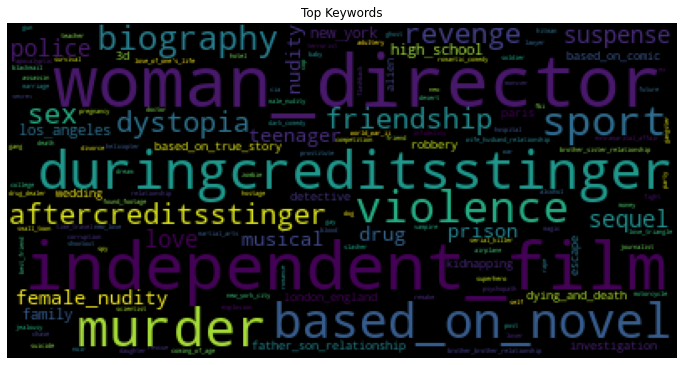

In [45]:
plt.figure(figsize=(12,10))
text3 = ' '.join(['_'.join(i.split(' ')) for j in list_of_keys for i in j])
wordcloud3 = WordCloud(collocations = False).generate(text3)
plt.imshow(wordcloud3)
plt.title('Top Keywords')
plt.axis('off')
plt.show()

In [46]:
train['num_of_keywords'] = train['Keywords'].apply(lambda x: len(x) if x!={} else 0)
test['num_of_keywords'] = test['Keywords'].apply(lambda x: len(x) if x!={} else 0)

train['all_keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name']for i in x]))
                                               if x!= {} else '')
test['all_keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x]))
                                             if x!={} else '')
for k in top_keywords:
    train['keyword_'+ k] = train['all_keywords'].apply(lambda x: 1 if k in x else 0)
    test['keyword_'+ k] = test['all_keywords'].apply(lambda x: 1 if k in x else 0)

train.drop(['Keywords','all_keywords'],axis=1,inplace=True)
test.drop(['Keywords','all_keywords'],axis=1,inplace=True)

#### Cast

In [47]:
for i, e in enumerate(train['cast'][:1]):
    print(i,e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [48]:
print('Number of casts used per movie:')
train['cast'].apply(lambda x: len(x) if x!={} else 0).value_counts().head(10)

Number of casts used per movie:


15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

In [49]:
list_cast_name = list(train['cast'].apply(lambda x: [i['name'] for i in x]if x!= {} else []))
top_cast_name = [m[0] for m in Counter(i for j in list_cast_name for i in j).most_common(20)]
Counter(i for j in list_cast_name for i in j).most_common(20)

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21),
 ('Jason Statham', 21),
 ('Keith David', 21),
 ('John Goodman', 21),
 ('Mel Gibson', 21),
 ('Sigourney Weaver', 21)]

In [51]:
list_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x!= {} else []).values)
Counter([i for j in list_cast_genders for i in j]).most_common()

[(2, 27949), (0, 20329), (1, 13533)]

0 is unspecified, 1 is female, and 2 is male. (https://www.kaggle.com/c/tmdb-box-office-prediction/discussion/80983#475572)

In [52]:
list_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x!={}
                                               else []))
top_cast_characters = [m[0] for m in Counter(i for j in list_cast_characters for i in j).most_common(15)]
Counter(i for j in list_cast_characters for i in j).most_common(15)


[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

In [53]:
train['num_of_cast']= train['cast'].apply(lambda x: len(x) if x!={} else 0)
test['num_of_cast'] = test['cast'].apply(lambda x: len(x) if x!={} else 0)

train['all_cast_name'] = train['cast'].apply(lambda x: ' '.join(sorted([i['name']for i in x]))
                                             if x!={} else '')
test['all_cast_name'] = test['cast'].apply(lambda x: ' '.join(sorted([i['name']for i in x]))
                                          if x!= {} else '')
for c in top_cast_name:
    train['cast_name_'+ c]= train['all_cast_name'].apply(lambda x: 1 if c in x else 0)
    test['cast_name_'+ c]= test['all_cast_name'].apply(lambda x: 1 if c in x else 0)
    
for m in top_cast_characters:
    train['cast_character_'+ m]= train['cast'].apply(lambda x: 1 if m in str(x) else 0)
    test['cast_character_'+ m]= test['cast'].apply(lambda x: 1 if m in str(x) else 0)

train['cast_gender_0'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['cast_gender_1'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['cast_gender_2'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

In [54]:
test['cast_gender_0'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['cast_gender_1'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['cast_gender_2'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

train.drop(['cast','all_cast_name'],axis=1,inplace=True)
test.drop(['cast','all_cast_name'],axis=1,inplace=True)

In [55]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,crew,revenue,collection_name,has_collection,num_of_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_prod_companies,production_Warner Bros.,production_Universal Pictures,production_Paramount Pictures,production_Twentieth Century Fox Film Corporation,production_Columbia Pictures,production_Metro-Goldwyn-Mayer (MGM),production_New Line Cinema,production_Touchstone Pictures,production_Walt Disney Pictures,production_Columbia Pictures Corporation,production_TriStar Pictures,production_Relativity Media,production_Canal+,production_United Artists,production_Miramax Films,production_Village Roadshow Pictures,production_Regency Enterprises,production_BBC Films,production_Dune Entertainment,production_Working Title Films,production_Fox Searchlight Pictures,production_StudioCanal,production_Lionsgate,production_DreamWorks SKG,production_Fox 2000 Pictures,production_Summit Entertainment,production_Hollywood Pictures,production_Orion Pictures,production_Amblin Entertainment,production_Dimension Films,num_prod_countries,prod_country_United States of America,prod_country_United Kingdom,prod_country_France,prod_country_Germany,prod_country_Canada,prod_country_India,prod_country_Italy,prod_country_Japan,prod_country_Australia,prod_country_Russia,prod_country_Spain,prod_country_China,prod_country_Hong Kong,prod_country_Ireland,prod_country_Belgium,prod_country_South Korea,prod_country_Mexico,prod_country_Sweden,prod_country_New Zealand,prod_country_Netherlands,prod_country_Czech Republic,prod_country_Denmark,prod_country_Brazil,prod_country_Luxembourg,prod_country_South Africa,prod_country_Hungary,prod_country_United Arab Emirates,prod_country_Austria,prod_country_Switzerland,prod_country_Romania,num_of_langs,lang_English,lang_Français,lang_Español,lang_Deutsch,lang_Pусский,lang_Italiano,lang_日本語,lang_普通话,lang_हिन्दी,lang_,lang_Português,lang_العربية,lang_한국어/조선말,lang_广州话 / 廣州話,lang_தமிழ்,num_of_keywords,keyword_woman director,keyword_independent film,keyword_duringcreditsstinger,keyword_murder,keyword_based on novel,keyword_violence,keyword_sport,keyword_biography,keyword_aftercreditsstinger,keyword_dystopia,keyword_revenge,keyword_friendship,keyword_sex,keyword_suspense,keyword_sequel,keyword_love,keyword_police,keyword_teenager,keyword_nudity,keyword_female nudity,num_of_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,cast_name_Jason Statham,cast_name_Keith David,cast_name_John Goodman,cast_name_Mel Gibson,cast_name_Sigourney Weaver,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,cast_gender_0,cast_gender_1,cast_gender_2
0,1,14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,2/20/15,93.0,Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Hot Tub Time Machine Collection,1,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Crew

In [56]:
for i,e in enumerate(train['crew'][:1]):
    print(i,e)

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [57]:
print('Number of crew members per movie:')
train['crew'].apply(lambda x: len(x) if x!= {} else 0).value_counts().head(10)

Number of crew members per movie:


2     179
11    127
10    126
3     126
12    110
9     109
8     109
14    104
4     101
7      94
Name: crew, dtype: int64

In [58]:
list_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x!= {} else []).values)
list_crew_department = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x!= {} else []).values)
list_crew_gender = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x!= {} else []).values)
list_crew_job = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x!= {} else []).values)

Counter(i for j in list_crew_names for i in j).most_common(25)


[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30),
 ('Jane Jenkins', 29),
 ('John Debney', 28),
 ('Hans Zimmer', 28),
 ('John Papsidera', 28),
 ('Francis Ford Coppola', 28),
 ('Billy Hopkins', 27),
 ('Danny Elfman', 27),
 ('Mindy Marin', 27),
 ('Hans Bjerno', 26),
 ('Sarah Finn', 26)]

In [59]:
Counter(i for j in list_crew_department for i in j).most_common(11)

[('Production', 15887),
 ('Sound', 9319),
 ('Art', 8069),
 ('Crew', 7315),
 ('Writing', 6567),
 ('Costume & Make-Up', 6156),
 ('Camera', 5424),
 ('Directing', 4954),
 ('Editing', 4508),
 ('Visual Effects', 3591),
 ('Lighting', 1303)]

In [60]:
Counter(i for j in list_crew_gender for i in j).most_common()

[(0, 41787), (2, 24898), (1, 6412)]

In [61]:
Counter(i for j in list_crew_job for i in j).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

In [62]:
top_crew_names = [m[0] for m in Counter(i for j in list_crew_names for i in j).most_common(25)]
top_crew_job = [m[0] for m in Counter(i for j in list_crew_job for i in j).most_common(15)]
top_crew_department = [m[0] for m in Counter(i for j in list_crew_department for i in j).most_common(11)]

In [63]:
train['num_of_crew'] = train['crew'].apply(lambda x: len(x) if x!= {} else 0)
test['num_of_crew']= test['crew'].apply(lambda x: len(x) if x!= {} else 0)
for cn in top_crew_names:
    train['crew_name_'+ cn]= train['crew'].apply(lambda x: 1 if cn in str(x) else 0)
    test['crew_name_'+ cn] = test['crew'].apply(lambda x: 1 if cn in str(x) else 0)

for cj in top_crew_job:
    train['crew_job_'+ cj] = train['crew'].apply(lambda x: sum([1 for i in x if i['job']==cj]))
    test['crew_job_'+ cj] = test['crew'].apply(lambda x: sum([1 for i in x if i['job']==cj]))

for cd in top_crew_department:
    train['crew_department_'+ cd] = train['crew'].apply(lambda x: sum([1 for i in x if i['department']==cd]))
    test['crew_department_'+ cd] = test['crew'].apply(lambda x: sum([1 for i in x if i['department']==cd]))
    
train['crew_gender_0']= train['crew'].apply(lambda x: sum([1 for i in x if i['gender']==0]))
train['crew_gender_1']= train['crew'].apply(lambda x: sum([1 for i in x if i['gender']==1]))
train['crew_gender_2']= train['crew'].apply(lambda x: sum([1 for i in x if i['gender']==2]))
test['crew_gender_0']= test['crew'].apply(lambda x: sum([1 for i in x if i['gender']==0]))
test['crew_gender_1']= test['crew'].apply(lambda x: sum([1 for i in x if i['gender']==1]))
test['crew_gender_2']= test['crew'].apply(lambda x: sum([1 for i in x if i['gender']==2]))

train.drop(['crew'],axis=1, inplace= True)
test.drop(['crew'],axis=1, inplace= True)

In [64]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,revenue,collection_name,has_collection,num_of_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_prod_companies,production_Warner Bros.,production_Universal Pictures,production_Paramount Pictures,production_Twentieth Century Fox Film Corporation,production_Columbia Pictures,production_Metro-Goldwyn-Mayer (MGM),production_New Line Cinema,production_Touchstone Pictures,production_Walt Disney Pictures,production_Columbia Pictures Corporation,production_TriStar Pictures,production_Relativity Media,production_Canal+,production_United Artists,production_Miramax Films,production_Village Roadshow Pictures,production_Regency Enterprises,production_BBC Films,production_Dune Entertainment,production_Working Title Films,production_Fox Searchlight Pictures,production_StudioCanal,production_Lionsgate,production_DreamWorks SKG,production_Fox 2000 Pictures,production_Summit Entertainment,production_Hollywood Pictures,production_Orion Pictures,production_Amblin Entertainment,production_Dimension Films,num_prod_countries,prod_country_United States of America,prod_country_United Kingdom,prod_country_France,prod_country_Germany,prod_country_Canada,prod_country_India,prod_country_Italy,prod_country_Japan,prod_country_Australia,prod_country_Russia,prod_country_Spain,prod_country_China,prod_country_Hong Kong,prod_country_Ireland,prod_country_Belgium,prod_country_South Korea,prod_country_Mexico,prod_country_Sweden,prod_country_New Zealand,prod_country_Netherlands,prod_country_Czech Republic,prod_country_Denmark,prod_country_Brazil,prod_country_Luxembourg,prod_country_South Africa,prod_country_Hungary,prod_country_United Arab Emirates,prod_country_Austria,prod_country_Switzerland,prod_country_Romania,num_of_langs,lang_English,lang_Français,lang_Español,lang_Deutsch,lang_Pусский,lang_Italiano,lang_日本語,lang_普通话,lang_हिन्दी,lang_,lang_Português,lang_العربية,lang_한국어/조선말,lang_广州话 / 廣州話,lang_தமிழ்,num_of_keywords,keyword_woman director,keyword_independent film,keyword_duringcreditsstinger,keyword_murder,keyword_based on novel,keyword_violence,keyword_sport,keyword_biography,keyword_aftercreditsstinger,keyword_dystopia,keyword_revenge,keyword_friendship,keyword_sex,keyword_suspense,keyword_sequel,keyword_love,keyword_police,keyword_teenager,keyword_nudity,keyword_female nudity,num_of_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,cast_name_Jason Statham,cast_name_Keith David,cast_name_John Goodman,cast_name_Mel Gibson,cast_name_Sigourney Weaver,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,cast_gender_0,cast_gender_1,cast_gender_2,num_of_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,crew_name_Jane Jenkins,crew_name_John Debney,crew_name_Hans Zimmer,crew_name_John Papsidera,crew_name_Francis Ford Co

#### Homepage

In [84]:
train['homepage'].isna().sum()

2054

In [88]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull()== False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1

IndexingError: (0       False
1       False
2        True
3        True
4       False
        ...  
2995    False
2996    False
2997    False
2998     True
2999     True
Name: homepage, Length: 3000, dtype: bool, 'has_homepage')

In [89]:
train.head()

,id,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,revenue,collection_name,has_collection,num_of_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,num_prod_companies,production_Warner Bros.,production_Universal Pictures,production_Paramount Pictures,production_Twentieth Century Fox Film Corporation,production_Columbia Pictures,production_Metro-Goldwyn-Mayer (MGM),production_New Line Cinema,production_Touchstone Pictures,production_Walt Disney Pictures,production_Columbia Pictures Corporation,production_TriStar Pictures,production_Relativity Media,production_Canal+,production_United Artists,production_Miramax Films,production_Village Roadshow Pictures,production_Regency Enterprises,production_BBC Films,production_Dune Entertainment,production_Working Title Films,production_Fox Searchlight Pictures,production_StudioCanal,production_Lionsgate,production_DreamWorks SKG,production_Fox 2000 Pictures,production_Summit Entertainment,production_Hollywood Pictures,production_Orion Pictures,production_Amblin Entertainment,production_Dimension Films,num_prod_countries,prod_country_United States of America,prod_country_United Kingdom,prod_country_France,prod_country_Germany,prod_country_Canada,prod_country_India,prod_country_Italy,prod_country_Japan,prod_country_Australia,prod_country_Russia,prod_country_Spain,prod_country_China,prod_country_Hong Kong,prod_country_Ireland,prod_country_Belgium,prod_country_South Korea,prod_country_Mexico,prod_country_Sweden,prod_country_New Zealand,prod_country_Netherlands,prod_country_Czech Republic,prod_country_Denmark,prod_country_Brazil,prod_country_Luxembourg,prod_country_South Africa,prod_country_Hungary,prod_country_United Arab Emirates,prod_country_Austria,prod_country_Switzerland,prod_country_Romania,num_of_langs,lang_English,lang_Français,lang_Español,lang_Deutsch,lang_Pусский,lang_Italiano,lang_日本語,lang_普通话,lang_हिन्दी,lang_,lang_Português,lang_العربية,lang_한국어/조선말,lang_广州话 / 廣州話,lang_தமிழ்,num_of_keywords,keyword_woman director,keyword_independent film,keyword_duringcreditsstinger,keyword_murder,keyword_based on novel,keyword_violence,keyword_sport,keyword_biography,keyword_aftercreditsstinger,keyword_dystopia,keyword_revenge,keyword_friendship,keyword_sex,keyword_suspense,keyword_sequel,keyword_love,keyword_police,keyword_teenager,keyword_nudity,keyword_female nudity,num_of_cast,cast_name_Samuel L. Jackson,cast_name_Robert De Niro,cast_name_Morgan Freeman,cast_name_J.K. Simmons,cast_name_Bruce Willis,cast_name_Liam Neeson,cast_name_Susan Sarandon,cast_name_Bruce McGill,cast_name_John Turturro,cast_name_Forest Whitaker,cast_name_Willem Dafoe,cast_name_Bill Murray,cast_name_Owen Wilson,cast_name_Nicolas Cage,cast_name_Sylvester Stallone,cast_name_Jason Statham,cast_name_Keith David,cast_name_John Goodman,cast_name_Mel Gibson,cast_name_Sigourney Weaver,cast_character_,cast_character_Himself,cast_character_Herself,cast_character_Dancer,cast_character_Additional Voices (voice),cast_character_Doctor,cast_character_Reporter,cast_character_Waitress,cast_character_Nurse,cast_character_Bartender,cast_character_Jack,cast_character_Debutante,cast_character_Security Guard,cast_character_Paul,cast_character_Frank,cast_gender_0,cast_gender_1,cast_gender_2,num_of_crew,crew_name_Avy Kaufman,crew_name_Robert Rodriguez,crew_name_Deborah Aquila,crew_name_James Newton Howard,crew_name_Mary Vernieu,crew_name_Steven Spielberg,crew_name_Luc Besson,crew_name_Jerry Goldsmith,crew_name_Francine Maisler,crew_name_Tricia Wood,crew_name_James Horner,crew_name_Kerry Barden,crew_name_Bob Weinstein,crew_name_Harvey Weinstein,crew_name_Janet Hirshenson,crew_name_Jane Jenkins,crew_name_John Debney,crew_name_Hans Zimmer,crew_name_John Papsidera,crew_name_Francis Ford Co

#### Original Language

In [93]:
print('Most common languages for the movies are in the order below:')
train['original_language'].value_counts().head(10)

Most common languages for the movies are in the order below:


en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
cn      20
ko      20
zh      19
Name: original_language, dtype: int64

#### Original Title

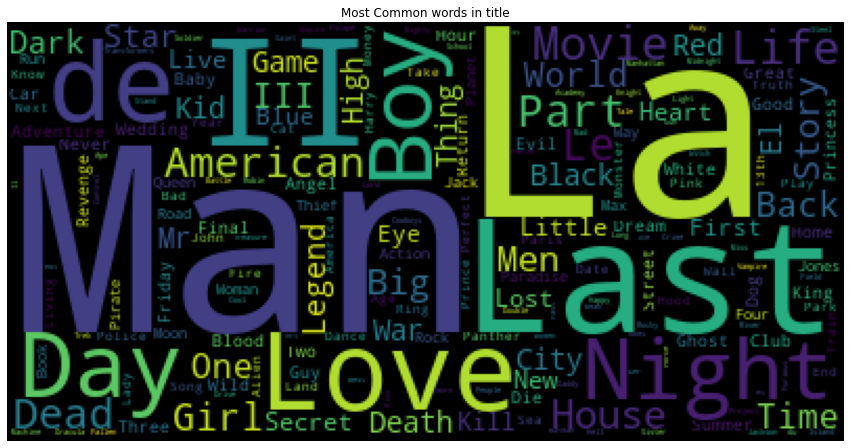

In [100]:
plt.figure(figsize=(15,15))
text4 = ' '.join(train['original_title'].values)
wordcloud = WordCloud(collocations=False).generate(text4)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Common words in title')
plt.show()

#### Overview

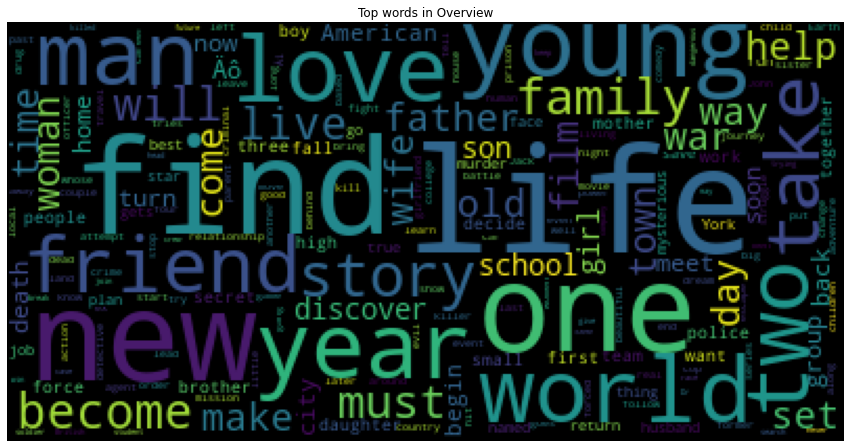

In [102]:
plt.figure(figsize=(15,12))
text5 = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(collocations=False).generate(text5)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Top words in Overview')
plt.show()

In [103]:
train['popularity'].isna().sum()

0

In [104]:
train['runtime'].isna().sum()

2

In [106]:
train['runtime'].fillna(train['runtime'].mean(),inplace= True)

In [105]:
train['status'].isna().sum()

0

#### Tagline

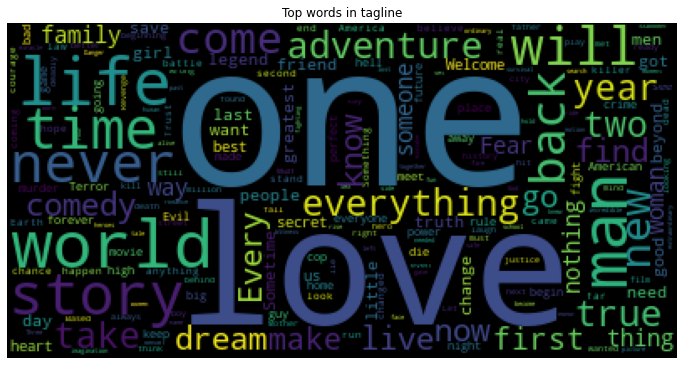

In [109]:
plt.figure(figsize=(12,12))
text6 = ' '.join(train['tagline'].fillna('').values)
wordcloud = WordCloud(collocations = False).generate(text6)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Top words in tagline')
plt.show()